In [4]:
#includes
%load_ext autoreload
%autoreload 2
import itertools
import random
import numpy as np
from music21 import *
import schillinger.rhythm as SRhythm
import schillinger.pitch as SPitch
import matplotlib.pyplot as plt
import math
%load_ext music21.ipython21

In [7]:
class SecondaryAxis:
    SA_Dict = {}
    def __init__(self, primary_axis,
                 motion_sequence, 
                 T, P, 
                 time_scale=1, 
                 motion_scale=1 ):
        self.SA_Dict = {}
        self.time_pointer = 0
        self.combinePA(primary_axis, motion_sequence,T,P, time_scale,motion_scale)
        self.T = T
        self.P = P
        self.time_scale = time_scale
        
    def combinePA(self, pa, ms, T, P, time_scale, motion_scale):
        
        for i in range(len(ms)):
            dd = self.calculate_seq(pa[i],ms[i], T[i%len(T)] * time_scale, P[i%len(P)]*motion_scale)
            self.SA_Dict[i] = dd
            #self.sequence_list.append()
            
    def calculate_seq(self, pa, motion_type, T, P):
        
        d = {}
        mt = []
        if motion_type == "a":
            mt = [pa, pa + P]
        elif motion_type == "b":
            mt = [pa + P, pa]
        elif motion_type == "c":
            mt = [pa - P, pa]
        elif motion_type == "d":
            mt = [pa, pa - P]
        elif motion_type == "0":
            mt = [pa, pa]
        
        d["PrimaryAxis"] = [pa,pa]
        d["Motion"] = motion_type
        d["RelativeTime"] = T
        d["AbsolutePitch"] = mt
        #d["AbsolutePitch"] = mt+pa
        d["AbsoluteTime"] = [self.time_pointer, self.time_pointer + T]
        
        self.time_pointer+=T
        
        return d
    def Plot(self):
        plt.title("AXIS MOTION")
        major_ticks = np.arange(-50, 100, 1)
        plt.axes().set_xticks(major_ticks)
        plt.axes().set_yticks(major_ticks)
        
        
        
        x = list((object['AbsoluteTime'] for object in SA.SA_Dict.values()))
        y = list((object['AbsolutePitch'] for object in SA.SA_Dict.values()))
        x = list(itertools.chain(*x))
        y = list(itertools.chain(*y))
        
        
        def convert_to_binary(data): # converting numbers  1 1 1 1 to oscillation 1 0 1 0 or 3 2 to 1 1 1 0 0
            plot_array_y = np.zeros(1, dtype=np.int32)
            plot_array_x = np.zeros(1, dtype=np.int32)
            for i, e in enumerate(data):
                y = np.ones(e+1, dtype=np.int32) if plot_array_y[-1] == 0 else np.zeros(e+1, dtype=np.int32)
                plot_array_y = np.append(plot_array_y, y)
                x = np.arange(len(y))+plot_array_x[-1]
                plot_array_x = np.append(plot_array_x, x)
            plot_array_y = np.append(plot_array_y, 0 if plot_array_y[-1] == 1 else 1)
            plot_array_x = np.append(plot_array_x, plot_array_x[-1])
            return plot_array_x,plot_array_y
        
        rt = list((object['RelativeTime'] for object in SA.SA_Dict.values()))
        
        binary_x, binary_y = convert_to_binary(rt)
        plt.plot(binary_x, binary_y + max(y) +1, color='black')
        
        
        plt.plot(x, y,color="black")
        
        pa = list((object['PrimaryAxis'] for object in SA.SA_Dict.values()))
        
        pa = list(itertools.chain(*pa))
        #print(pa,x)
        plt.plot(x, pa, color="blue")
        
        plt.grid(which="both")#linestyle='-'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis([-1, x[-1]+1, min(y) -1, max(y) +3])
        plt.show()
        #return plt
        
    

In [8]:
#Helpers
def movementArrayToString(motion,time,pitch):
    s = ""
    for i, m in enumerate(motion):
        t = "T" if time[i] <= 1 else str(time[i]) + "T"
        p = "P" if pitch[i] <= 1 else str(pitch[i]) + "P"
        #s.append(motion[i] + t + p)
        s = s + motion[i] + t + p
    return s
#movementArrayToString(M,T,P)
def movementStringToArray(mov_string):
   
    times = []
    pitches = []
    m_temp = []
    
    for i in range(len(mov_string)):
        e = mov_string[i]
        if e == "a" or e == "b" or e == "c" or e == "d" or e == "0":
            m_temp.append(e)
        else:
            if e.isdecimal():
                if mov_string[i+1] == "P":
                    pitches.append(int(e))
                else:
                    times.append(int(e))
            elif not mov_string[i-1].isdecimal():
                if e == "P":
                    pitches.append(1)
                else:
                    times.append(1)
    return m_temp, times, pitches
#l = "04TP" + "b2TP" + "02TP"
#M, T, P = movementStringToArray(l)
#M,T,P, 
#movementArrayToString(M,T,P)

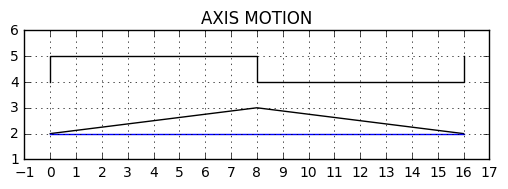

{0: {'AbsolutePitch': [2, 3],
  'AbsoluteTime': [0, 8],
  'Motion': 'a',
  'PrimaryAxis': [2, 2],
  'RelativeTime': 8},
 1: {'AbsolutePitch': [3, 2],
  'AbsoluteTime': [8, 16],
  'Motion': 'b',
  'PrimaryAxis': [2, 2],
  'RelativeTime': 8}}

In [157]:
M = ["a","b"]
T = [4,4]
P = [1,1]
pa = [2] #Primary Axis
PA = np.kron(pa, np.ones(len(M),dtype=np.int32))
SA = SecondaryAxis(PA, M, T, P, time_scale=2, motion_scale=1)
SA.Plot()
#plt.show()
SA.SA_Dict

In [158]:
class MelodyStructure:
    
    Melody_Dict = {}
    def __init__(self, secondary_axis, melody_rhythm, motion):#
        self.Melody_Dict = {}
        motion_resized = np.kron(motion, np.ones(len(melody_rhythm),dtype=np.chararray))
        at = self.convertRelativeToAbsolute(melody_rhythm)
        
        self.Melody_Dict = self.makeMelody(melody_rhythm, at, secondary_axis.SA_Dict, motion_resized)
        
    def makeMelody(self, melody_rhythm, absolute_time, SA_Dict, motion):
        d = {}
        step_count = 0
        for i , e in enumerate(SA_Dict.values()):
            X_temp_end = e["AbsoluteTime"][1]
            X_temp_start = e["AbsoluteTime"][0]
            X_steps = e["RelativeTime"]
            
            Y_start = e["AbsolutePitch"][0]
            Y_stop = e["AbsolutePitch"][1]
            
            tx = np.arange(0, X_steps, 1)#make x steps
            ty = np.linspace(Y_start, Y_stop, len(tx))#layout y steps on x axis
            
            count=0
            for r in range(X_steps):
                X = X_temp_start+count # make X absolute in time
                if X in absolute_time:
                    
                    Y = ty[r]
                    #convert to ascribed or inscribed motion
                    if(motion[i] =='ascribed' and (e['Motion'] is "a" or e['Motion'] is "b")):
                        Y = np.ceil(Y)
                    elif(motion[i] =='inscribed' and (e['Motion'] is "a" or e['Motion'] is "b")):
                        Y = np.floor(Y)
                    elif(motion[i] =='ascribed' and (e['Motion'] is "c" or e['Motion'] is "d")):
                        Y = np.floor(Y)
                    elif(motion[i] =='inscribed' and (e['Motion'] is "c" or e['Motion'] is "d")):
                        Y = np.ceil(Y)
                    else:
                        Y = np.floor(Y)
                    d[step_count] = {"AbsoluteTime": [X, X+melody_rhythm[step_count]],
                                     "Pitch": [int(Y),int(Y)], 
                                     "RelativeTime":melody_rhythm[step_count],
                                     "Motion": motion[i]}
                    step_count+=1
                count+=1
        return d
    
    def correctMelodyRhythmLength(self,resultant,length):
        r = []
        for i in range(length):
            if(sum(r)<length):
                r.append(resultant[i%len(resultant)])
            else:
                break
        return r #len(resultant)==len(seq_lentgh)
    def convertRelativeToAbsolute(self, resultant):
        #convert "resultant" relative to absolute time
        time_pointer = 0
        abs_resultant = [0]
        for i in resultant:
            abs_resultant.append(i+time_pointer)
            time_pointer+=i
        return abs_resultant # 0,1,2,2 -> 0,1,3,5
    def Plot(self):
        plt.title("MELODY STRUCTURE")
        major_ticks = np.arange(-50, 100, 1)
        plt.axes().set_xticks(major_ticks)
        plt.axes().set_yticks(major_ticks)
        
        x = list((object['AbsoluteTime'] for object in self.Melody_Dict.values()))
        y = list((object['Pitch'] for object in self.Melody_Dict.values()))
        x = list(itertools.chain(*x))
        y = list(itertools.chain(*y))
        
        
        def convert_to_binary(data): # converting numbers  1 1 1 1 to oscillation 1 0 1 0 or 3 2 to 1 1 1 0 0
            plot_array_y = np.zeros(1, dtype=np.int32)
            plot_array_x = np.zeros(1, dtype=np.int32)
            for i, e in enumerate(data):
                y = np.ones(e+1, dtype=np.int32) if plot_array_y[-1] == 0 else np.zeros(e+1, dtype=np.int32)
                plot_array_y = np.append(plot_array_y, y)
                x = np.arange(len(y))+plot_array_x[-1]
                plot_array_x = np.append(plot_array_x, x)
            plot_array_y = np.append(plot_array_y, 0 if plot_array_y[-1] == 1 else 1)
            plot_array_x = np.append(plot_array_x, plot_array_x[-1])
            return plot_array_x,plot_array_y
        
        rt = list((object['RelativeTime'] for object in self.Melody_Dict.values()))
        
        binary_x, binary_y = convert_to_binary(rt)
        plt.plot(binary_x, binary_y + max(y) +1, color='black')
        
        
        plt.plot(x, y,color="black")
        
        plt.grid(which="both")#linestyle='-'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis([-1, x[-1]+1, min(y) -1, max(y) +3])
        plt.show()

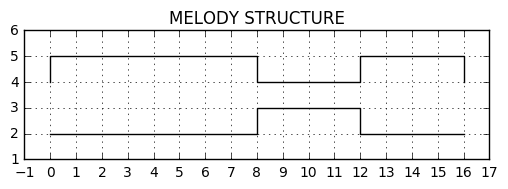

{0: {'AbsoluteTime': [0, 8],
  'Motion': 'inscribed',
  'Pitch': [2, 2],
  'RelativeTime': 8},
 1: {'AbsoluteTime': [8, 12],
  'Motion': 'inscribed',
  'Pitch': [3, 3],
  'RelativeTime': 4},
 2: {'AbsoluteTime': [12, 16],
  'Motion': 'inscribed',
  'Pitch': [2, 2],
  'RelativeTime': 4}}

In [161]:
mel_rhythm = [8,4,4]
mel_motions = ["inscribed"]
MS = MelodyStructure(SA, mel_rhythm, mel_motions)
MS.Plot()
MS.Melody_Dict

In [160]:
def numpy_oscillator(length):
    axis1 = np.zeros(length, dtype=np.int32)
    axis2 = np.linspace(1,length,length, dtype=np.int32)
    #axis1 = 0
    #axis2 = 1
    #axis3 = nan
    b = np.linspace(1,length,length, dtype=np.int32)
    c = np.negative(b)
    #y = np.linspace(0,0,1)
    #print(np.linspace(1,5,5, dtype=np.int32))
    #z[1:length:2] = 1
    
    #o = zip(x,y)
    
    return np.dstack((b,c)).ravel()
#aTP  
numpy_oscillator(5)

array([ 1, -1,  2, -2,  3, -3,  4, -4,  5, -5], dtype=int32)

In [112]:
0 1 1 -4 3 -1 -1 1 2 -2

In [ ]:
# Step Movement Investigation on an classical 7 step scale ->

0

0

0

In [ ]:
#Melody show helpers
def convert_to_music21_sequence(sc, pa, pitches, durations):
    note_seq = []
    
    tonic = sc.getTonic()
    
    for e, p in enumerate(pitches):
        if p != 0:
            c = sc.next(tonic, direction=p)
        else:
            c = tonic
        #print(c,p)
        nota = note.Note(c.nameWithOctave)
        nota.duration.quarterLength = int(durations[e])
        note_seq.append(nota)
        
    return note_seq
# simple notes show
def showNotes(note_sequece, time_meter, duration_divider):
    TS = str(time_meter[0])+'/'+str(time_meter[1])
    s = stream.Score(id='mainScore')
    p0 = stream.Part(id='part0')
    p0.timeSignature = meter.TimeSignature(TS)
    for i, notes in enumerate(note_sequece):
        notes.quarterLength = notes.quarterLength*duration_divider
        p0.append(notes)
    s.insert(0, p0)
    return s

In [ ]:
#Show Melody Notes
melody = ME2.oscillated_seq
hm = scale.HarmonicMinorScale("C4")
#hm = scale.ChromaticScale(tonic="C4")
pitches = convert_to_music21_sequence(hm, PA, melody[1], melody[0])
s = showNotes(pitches,[4,4],1)
s.show('musicxml')

In [ ]:
# notes harmony 

def arpeggiator(c, es,rhythm, duration_divider):
    chords = []
    for i, seq in enumerate(c):
                
        nota = seq
        nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
        chords.append(nota)

    nota = pitch.Pitch(c.pitches[0])
    
    
    nota.octave = nota.octave + 2
    nota = note.Note(nota.nameWithOctave)
    #nota.duration.quarterLength = rhythm[es%len(rhythm)] * duration_divider
    nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
    
   
    chords.append(nota)
    #octave adjust
    
    
    #print(chords[-1].pitch.midi - chords[-2].pitch.midi, chords[-1])
    if chords[-1].pitch.midi - chords[-2].pitch.midi >= 11:
        chords[-1].octave = chords[-1].octave -1
        #print("yes")
    ##
    nota = pitch.Pitch(c.pitches[2])
    nota.octave = nota.octave
    nota = note.Note(nota.nameWithOctave)
    #nota.duration.quarterLength = rhythm[es%len(rhythm)] * duration_divider
    nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
    chords.append(nota)
    return chords

def showHarmony(pitches, note_sequence, scala, rhythm, length, time_meter, duration_divider, arp=False,bass=True, drop2 = False):
    TS = str(time_meter[0])+'/'+str(time_meter[1])
    
    s = stream.Score(id='mainScore')
    p0 = stream.Part(id='melody')
    p0.timeSignature = meter.TimeSignature(TS)
    p1 = stream.Part(id='chords')
    p1.timeSignature = meter.TimeSignature(TS)
    
    #pseudo stuff
    #temp_scale = scala
    #rhythm_seq = [2,1,1,2]
    for es, sequences in enumerate(note_sequence):
        
        melody = []
        chords = []
        
        
        
        ### chords
        #chord_seq = [sequences[0]]+sequences[1]
        chord_seq = sequences
        #print(chord_seq)
        test_chord = chord.Chord(chord_seq)
        c = chord.Chord(test_chord)
        #c.root = sequences[0]
        #pitches[es].quarterLength.duration
        c.quarterLength = pitches[es].quarterLength * duration_divider
        #c = c.sortDiatonicAscending() # for better voice leadng but not real!
        #c.pitches.octave = 2
        for p in c.pitches:
            p.octave = 3
        if drop2:
            try:
                #
                #c.pitches[0].octave = 1 # drop2
                #c.pitches[-2].octave -= 2 # drop4
                pass
            except:
                pass
        
        if arp:
            chords =  arpeggiator(c, es, rhythm, duration_divider)
            #chords.append(nota)
            
        else:
            chords.append(c)
            
        nota = pitches[es]
        nota.quarterLength *= duration_divider
        #nota.octave += 1 
        melody.append(pitches[es])
            
        
        ##############
        # pseudo BASS
        # get chord durations and apply on melody (for test purpose)
        
        p0.append(melody)
        p1.append(chords)
        
    
    s.insert(0, p0)
    s.insert(0, p1)
    
    #s = s.transpose(0)
    return s



In [ ]:
#'harmonized'
def harmonize_note_clockwise(n, chordified_scale, clock_position):
    dummy = []
    temp_scales = []
    for i,e in enumerate(chordified_scale):
        if n in e:
            temp_scales.append(e)
    dummy.append(temp_scales[clock_position%len(temp_scales)])
    return dummy

melody = ME.oscillated_seq
hm = scale.HarmonicMinorScale("C4")
#hm = scale.ChromaticScale(tonic="C4")
notes = convert_to_music21_sequence(hm, PA, melody[1], melody[0])
note_seq = [[str(p.name) for p in notes]]

temp_scale = [str(p.name) for p in hm.pitches[:-1]]
scales = [temp_scale]
#print(scales)
#note_seq = bass
voice_amount = 3 
theme_expansion = 0
scale_expansion_amount = 1 # # 1st order expansion for harmonizing is according to schillingers default

SPG = SPitch.PitchGroup()
harmonized_note_sequence_array = []
scale_expansion = SPG.expansions(temp_scale)
scale_ = scale_expansion[scale_expansion_amount]
chordified_scale = SPG.chordify_scale(scale_, voice_amount)
#TSD = [chordified_scale[0],chordified_scale[2],chordified_scale[5],chordified_scale[6]]
TSD = chordified_scale.copy()
#print(chordified_scale)
for i,no in enumerate(note_seq[0]):
    clock_position = i
    hn = harmonize_note_clockwise(no, TSD, clock_position)
    harmonized_note_sequence_array.append(hn)
    
merged_seq = list(itertools.chain(*harmonized_note_sequence_array))
s = showHarmony(notes, merged_seq, hm, melody[0], len(merged_seq)*2, (4,4), .5, arp=False, bass=False, drop2=True)
s.show('musicxml')

In [ ]:
#np.negative(np.arange(-5, 0, 1))
#random.choice([a.min(),a.max()])
#random.choice([True,False])
#np.random.randint(0,PA.durations[i])

In [ ]:
#OSCILLATOR

def sinusCycle(steps, amplitude, cycles, full_cycle=True, sin=True):
    
    if full_cycle:
        magnitude = 360
    else:
        magnitude = 180
    
    R = np.array(np.sin(np.arange(0, magnitude, magnitude/steps) * np.pi / 180.)*amplitude, dtype=np.float32)
    
    if not sin:
        R = np.roll(R, int(steps/2))
    
    if steps<0:
        R = np.negative(R)
        
    return np.tile(np.array(np.rint(R), dtype=np.int32), cycles)

def growSeq(np_array, start_amount=1, end_amount=5):
    c = np_array.copy()
    dummy = np.linspace(start_amount, end_amount, len(np.nonzero(c)[0]), endpoint=True, dtype=np.int32)
    c[np.nonzero(c)] *= dummy
    return c

def shiftSeq(np_array, start_amount=0, end_amount=1):
    c = np_array.copy()
    dummy = np.linspace(start_amount, end_amount, len(c), endpoint=True, dtype=np.int32)
    c += dummy
    return c

steps=4
amplitude = 1
cycles = 1
X = sinusCycle(steps, amplitude, cycles, full_cycle=True, sin=True)
X
Y = growSeq(X, start_amount=1, end_amount=2)
Y

In [ ]:
0--6

In [ ]:
steps = np.arange(0, 10, 1)
amp = 45
amplitude = np.radians(amp)/np.pi/2
amplitude * steps


np.tile(np.array([0,1,0,-1], dtype=np.int32), 1)